In [182]:
import data_handler
import machine_learning as ml
import cost_benefit as cb

import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib
import graphviz 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main results for seminar paper
This notebook is created to estimate the machine learning models for the chosen hyperparameters. See other notebook for invokement of the grid search algorithm to choose the optimal hyperparameters.

### Ohlson's Logit
I first define a function to run Ohlson's logit function, with the specified variables. I then evaluate it both in it's success at predicting bankruptcies, but also how much savings we expect.

In [183]:
x_train, x_test, y_train, y_test = data_handler.ohlson_data(5)
ohlson_parameters = {'penalty': 'none', 'max_iter': 1000}
ohlson_logit = cb.result_wrapper(LogisticRegression, ohlson_parameters, (x_train, y_train), (x_test, y_test), "Ohlson's logit", scoring='roc_auc') 
ox_test, oy_test = x_test, y_test

\begin{table}[!hb]
\centering
\label{tab:Ohlson's logit}
\caption{Confusion matrix for Ohlson's logit model} 
\caption*{Train Results with area under the curve score of 0.798}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{4379}$ & $\underset{(0.005)}{21}$ \\ 
Bankrupt & $\underset{(0.933)}{306}$ & $\underset{(0.067)}{22}$ \\ 
\hline
\end{tabular}
\caption*{Test Results with area under the curve score of 0.763}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{1095}$ & $\underset{(0.005)}{5}$ \\ 
Bankrupt & $\underset{(0.963)}{79}$ & $\underset{(0.037)}{3}$ \\ 
\hline
\end{tabular}
\medskip

\footnotesize\noindent
Note: Results from Ohlson's logit model plotted as a confusion matrix. Each cell contains the number of firms, with row percentages in the paranthesis.
\end{table}


### Logit with elastic net
This is an extension of Ohlson's logit model. This time we include all available variables. Since this can lead to overfitting, we use elastic-net to reduce this problem.

In [184]:
x_train, x_test, y_train, y_test = data_handler.load_data(5, out_frame=False)
logit_parameters = {
    'C': 1.2, 
    'l1_ratio': 0,
    'penalty': 'elasticnet', 
    'solver': 'saga',
    'max_iter': 500
}
logit_best_model = cb.result_wrapper(LogisticRegression, logit_parameters, (x_train, y_train), (x_test, y_test), "Logit", scoring='roc_auc')

/Users/karl/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
\begin{table}[!hb]
\centering
\label{tab:Logit}
\caption{Confusion matrix for Logit model} 
\caption*{Train Results with area under the curve score of 0.819}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.995)}{4376}$ & $\underset{(0.005)}{24}$ \\ 
Bankrupt & $\underset{(0.918)}{301}$ & $\underset{(0.082)}{27}$ \\ 
\hline
\end{tabular}
\caption*{Test Results with area under the curve score of 0.775}
\begin{tabular}{lcc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt \\
\hline
Non-Bankrupt & $\underset{(0.994)}{1093}$ & $\underset{(0.006)}{7}$ \\ 
Bankrupt & $\underset{(0.89)}{73}$ & $\underset{(0.11)}{9}$ \\ 
\hline
\end{tabular}
\medskip

\footnotesize\noindent
Note: R

This prints the most important logit coefficients

In [185]:
cb.print_important_coeff(logit_best_model, 10) ;

\begin{tabular}{llll}
\hline
 net profit / total assets & -0.402                                                                                          & retained earnings / total assets & 0.27          \\
 total liabilities / total assets & -0.394                                                                                   & EBIT / total assets & -0.164                     \\
 working capital / total assets & -0.392                                                                                     & book value of equity / total liabilities & 0.155 \\
 current assets / short-term liabilities & -0.39                                                                             & sales / total assets & -0.15                     \\
 defensive interval ratio & -0.38 & equity / total assets & -0.146                   \\
\hline
\end{tabular}


### Decision Tree

In [186]:
dt_parameters = {
    'max_leaf_nodes': 11,  #19
    'max_depth': 5,  #7
    'min_samples_leaf': 0.01,
    'min_samples_split': 0.01,
    'min_weight_fraction_leaf': 0,
    'min_impurity_decrease': 0
}
dt_best_model = cb.result_wrapper(
    DecisionTreeClassifier, dt_parameters, (x_train, y_train), (x_test, y_test), "Decision Tree", baseline=logit_best_model, scoring='roc_auc')

\begin{table}[!hb]
\centering
\label{tab:Decision Tree}
\caption{Confusion matrix for Decision Tree model} 
\caption*{Train Results with area under the curve score of 0.898}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.985)}{4333}$ & $\underset{(0.015)}{67}$ & \makecell{Type 1 \\ errors} & $\underset{(0.01)}{43}$ \\ 
Bankrupt & $\underset{(0.473)}{155}$ & $\underset{(0.527)}{173}$ & \makecell{Type 2 \\ errors} & $\underset{(-0.445)}{-146}$ \\ 
\hline
\end{tabular}
\vspace{1cm}
\caption*{Test Results with area under the curve score of 0.825}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.975)}{1072}$ & $\underset{(0.025)}{28}$ & \makecell{Type 1 \\ errors} & $\underset{(0.019)}{21}$ \\ 
Bankrupt & $\underset{(0.537)}{44}$ & $\underset{(0.463)}{38}

In [187]:
dot_data = tree.export_graphviz(
    dt_best_model['estimator'], 
    out_file=None, 
    feature_names=data_handler.ohlson_varnames(),
    class_names=['non-bankrupt', 'bankrupt'],
    rounded=True, filled=True
) 
graph = graphviz.Source(dot_data) 
graph.render("bankruptcy") 

'bankruptcy.pdf'

### Gradient Descent classifier

In [188]:
GBC_parameters = {
    "learning_rate": 0.9,
    "min_samples_split": 0.005,
    "min_samples_leaf": 0.005,
    "max_depth": 8,
    'random_state': 42
}
gbc_results = cb.result_wrapper(
    GradientBoostingClassifier, GBC_parameters, (x_train, y_train), (x_test, y_test), "Gradient Boosting", scoring='roc_auc', baseline=logit_best_model
) ;

\begin{table}[!hb]
\centering
\label{tab:Gradient Boosting}
\caption{Confusion matrix for Gradient Boosting model} 
\caption*{Train Results with area under the curve score of 1.000}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.998)}{4391}$ & $\underset{(0.002)}{9}$ & \makecell{Type 1 \\ errors} & $\underset{(-0.003)}{-15}$ \\ 
Bankrupt & $\underset{(0.076)}{25}$ & $\underset{(0.924)}{303}$ & \makecell{Type 2 \\ errors} & $\underset{(-0.842)}{-276}$ \\ 
\hline
\end{tabular}
\vspace{1cm}
\caption*{Test Results with area under the curve score of 0.914}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.985)}{1084}$ & $\underset{(0.015)}{16}$ & \makecell{Type 1 \\ errors} & $\underset{(0.009)}{9}$ \\ 
Bankrupt & $\underset{(0.341)}{28}$ & $\underset{(0.6

### Neural network


In [189]:
nn_parameters = {
    'solver': 'lbfgs',
    'random_state': 42,
    'warm_start': False,
    'hidden_layer_sizes': 190,
    'max_iter': 200
}
nn_results = cb.result_wrapper(MLPClassifier, nn_parameters, (x_train, y_train), (x_test, y_test), "Neural network", scoring='roc_auc', baseline=logit_best_model) ;

/Users/karl/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
\begin{table}[!hb]
\centering
\label{tab:Neural network}
\caption{Confusion matrix for Neural network model} 
\caption*{Train Results with area under the curve score of 0.997}
\begin{tabular}{lcc||lc}
\hline
\backslashbox{Actual}{Predicted} & Non-Bankrupt & Bankrupt & & \makecell{Baseline \\ comparison} \\
\hline
Non-Bankrupt & $\underset{(0.991)}{4361}$ & $\underset{(0.009)}{39}$ & \makecell{Type 1 \\ errors} & $\underset{(0.004)}{15}$ \\ 
Bankrupt & $\underset{(0.155)}{51}$ & $\underset{(0.845)}{277}$ & \makecell{Type 2 \\ errors} & $\underset{(-0.763)}{-250}$ \\ 
\hline
\

# Plot all the ROC-curves together

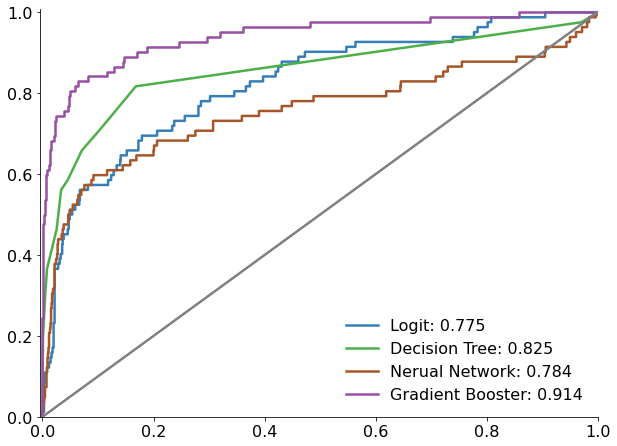

In [190]:
all_models = [logit_best_model, dt_best_model, nn_results, gbc_results]
cb.roc_plotter((x_test, y_test), all_models)

# Print out the cost-savings tables

In [191]:
def cost_saving_table(
        data: tuple, ohlson_data: tuple, models: list, errorI=False, header=None, table_notes='', name_list=["Ohlson's Logit", 'Logit', 'Decision Tree', 'Nerual Network', 'Gradient Booster']
    ):
    if not header:
        header = ["Model", "\\makecell[c]{Correct \\\\ predicted}", "\\makecell[c]{Saving Low \\\\ (pct.)}", "\makecell[c]{Saving High \\\\ (pct.)} \\\\ "]
    cb.latex_table_start('Possible cost savings based on model performance.')
    print("\\begin{tabular}{lccc}")
    print(" & ".join(header))
    print("\\hline")
    for i, model in enumerate(models):
        row = cb.cost_benefit_analysis(model, data, ohlson_data, errorI)
        row.insert(0, name_list[i])  # Add name to row
        # row = [str(i) for i in row]
        print(f'{row[0]} & {" & ".join(row[1:])} \\\\')
    print("\\hline")
    print("\\hline")
    print("\\end{tabular}")
    cb.latex_table_end("Savings are based on the value of the firm's assets if we correctly predict that it went bankrupt. We have a low and a high estimate for how much of the firm's assets we are able to recuperate, based on the low and high cost saving estimates by Branch (2002). " + table_notes)
        #row = ["{" + i + ":.2f}" for i in row]
        #row = " & ".join(row)
        
        #print(f"{row}")
        #print(f"{name_list[i]} & {benefits[3]} & {benefits[0]:.2f} & {benefits[1]/benefits[0]*100:.2f} & {benefits[2]/benefits[0]*100:.2f} \\\\")

In [194]:
all_models.insert(0, ohlson_logit)

In [195]:
cost_saving_table((x_test, y_test), (ox_test, oy_test), all_models)

\begin{table}[!hb]
\centering
\label{tab:Possible cost savings based on model performance.}
\caption{Confusion matrix for Possible cost savings based on model performance. model} 
\begin{tabular}{lccc}
Model & \makecell[c]{Correct \\ predicted} & \makecell[c]{Saving Low \\ (pct.)} & \makecell[c]{Saving High \\ (pct.)} \\ 
\hline
Ohlson's Logit & 3 & 0.11 & 0.18 \\
Logit & 9 & 0.49 & 0.79 \\
Decision Tree & 38 & 5.88 & 9.5 \\
Nerual Network & 32 & 5.77 & 9.31 \\
Gradient Booster & 54 & 7.95 & 12.84 \\
\hline
\hline
\end{tabular}
\medskip

\footnotesize\noindent
Savings are based on the value of the firm's assets if we correctly predict that it went bankrupt. We have a low and a high estimate for how much of the firm's assets we are able to recuperate, based on the low and high cost saving estimates by Branch (2002). 
\end{table}


In [196]:
header = ["Model", "\\makecell[c]{Correct \\\\ predicted}", "\\makecell[c]{Type I \\\\ errors}", "\\makecell[c]{Saving Low \\\\ (pct.)}", "\makecell[c]{Saving High \\\\ (pct.)} \\\\ "]
cost_saving_table((x_test, y_test), (ox_test, oy_test), all_models, header=header, errorI=True)

\begin{table}[!hb]
\centering
\label{tab:Possible cost savings based on model performance.}
\caption{Confusion matrix for Possible cost savings based on model performance. model} 
\begin{tabular}{lccc}
Model & \makecell[c]{Correct \\ predicted} & \makecell[c]{Type I \\ errors} & \makecell[c]{Saving Low \\ (pct.)} & \makecell[c]{Saving High \\ (pct.)} \\ 
\hline
Ohlson's Logit & 3 & 5 & 0.09 & 0.15 \\
Logit & 9 & 7 & 0.35 & 0.65 \\
Decision Tree & 38 & 28 & 5.27 & 8.88 \\
Nerual Network & 32 & 29 & 4.85 & 8.39 \\
Gradient Booster & 54 & 16 & 7.68 & 12.56 \\
\hline
\hline
\end{tabular}
\medskip

\footnotesize\noindent
Savings are based on the value of the firm's assets if we correctly predict that it went bankrupt. We have a low and a high estimate for how much of the firm's assets we are able to recuperate, based on the low and high cost saving estimates by Branch (2002). 
\end{table}
